<a href="https://colab.research.google.com/github/mixhub10/car-late-payment/blob/main/%EC%BA%90%ED%94%BC%ED%83%88_%EC%97%B0%EC%B2%B4%EC%98%88%EC%B8%A1(%ED%87%B4%EC%A7%81%EC%9E%90).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.formula.api as smf

In [ ]:
import matplotlib.pyplot as plt # 다운 받은 글꼴 plt에 적용
plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
dfloan_train = pd.read_csv('/home/piai/test/Data3/auto_loan_train.csv', encoding = 'euc-kr')
dfc_train = pd.read_csv('/home/piai/test/Data3/auto_customer_train.csv', encoding = 'euc-kr')
dfloan_test = pd.read_csv('/home/piai/test/Data3/auto_loan_test.csv', encoding = 'euc-kr')
dfc_test = pd.read_csv('/home/piai/test/Data3/auto_customer_test.csv', encoding = 'euc-kr')

# 데이터 전처리

In [ ]:
df = pd.merge(dfc_train,dfloan_train, how='right',on='CustomerId')
df = df.drop(['CustomerId','LoanId','HouseAge'], axis = 1)

* CustomerId, LoanId: 분석과 관련없는 열 제거(ID)
* HouseAge: 결측치가 너무 많아 열 제거

In [ ]:
# 퇴직자, 재직자 분리
df_em = df[(df['IncomeType'] == '퇴직')]
df = df[(df['IncomeType'] != '퇴직')]

* 재직자와 퇴직자의 특성이 달라(직장, 수입 등) 분할하여 데이터 분석 진행

In [ ]:
df_em = df_em[df_em['IncomeClass'] != '누락']
df_em = df_em[df_em['ResidenceClass'] != '누락']
df_em = df_em[df_em['DwellingType'] != '정보누락']

* 누락값 제거

In [ ]:
df_em = df_em.dropna(subset=['IdChangedYears'])
df_em = df_em.dropna(subset=['PhoneChangedYears'])

* 결측치(NaN 값) 제거

In [ ]:
# 값이 '퇴직'으로 구성된 열 삭제
df_em = df_em.drop(['EmployedYears', 'IncomeType','Occupation','WorkAddMatchedYN'], axis =1)

* 값이 '퇴직'으로 구성된 열 삭제
  ex) IncomeType: 퇴직, Occupation: 퇴직자

In [ ]:
df_em['Accompany'].replace(['기타','배우자','친지','자녀','단체'],'동행', inplace = True)

* 동행 혹은 단독으로 범주화

# EDA

### LoanType

In [ ]:
df_em['LoanType'].value_counts()

할부금융(장/단기)    12629
오토론            1177
Name: LoanType, dtype: int64

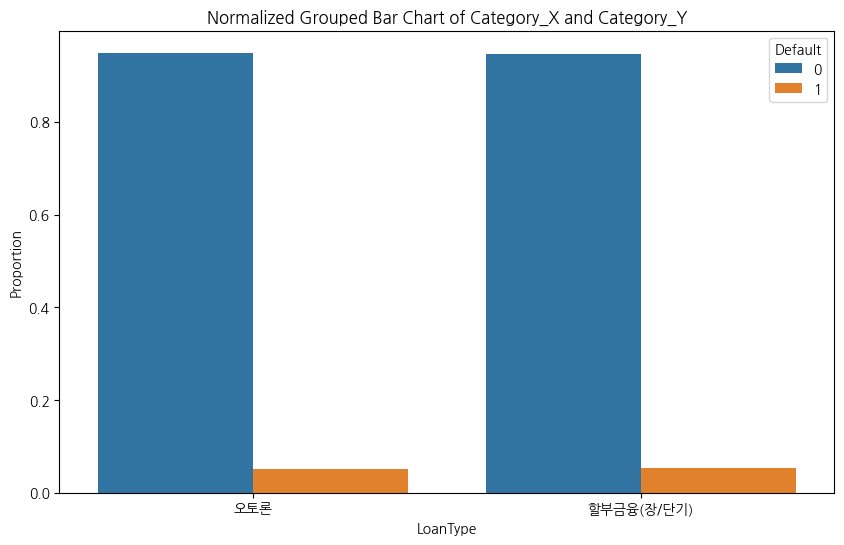

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['LoanType', 'Default']).size() / df_em.groupby('LoanType').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='LoanType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

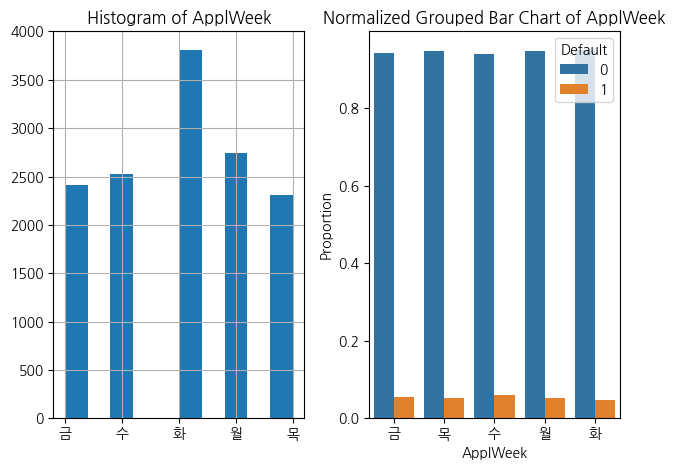

In [ ]:
plt.subplot(1, 2, 1)
df_em['ApplWeek'].hist()
plt.title('Histogram of ApplWeek')

# 두 번째 서브플롯 - 그룹별 막대 그래프
plt.subplot(1, 2, 2)
normalized_counts = df_em.groupby(['ApplWeek', 'Default']).size() / df_em.groupby('ApplWeek').size()
sns.barplot(x='ApplWeek', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of ApplWeek')
plt.ylabel('Proportion')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

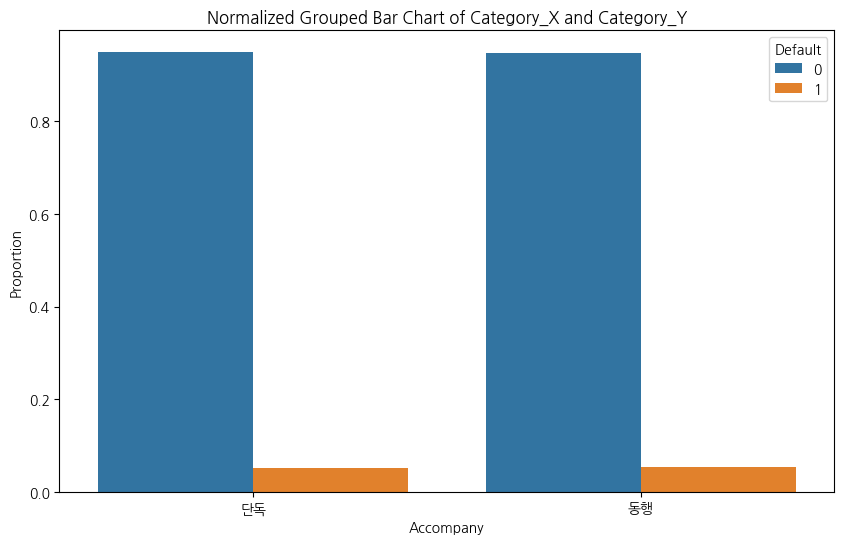

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Accompany', 'Default']).size() / df_em.groupby('Accompany').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Accompany', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

Text(0, 0.5, 'Proportion')

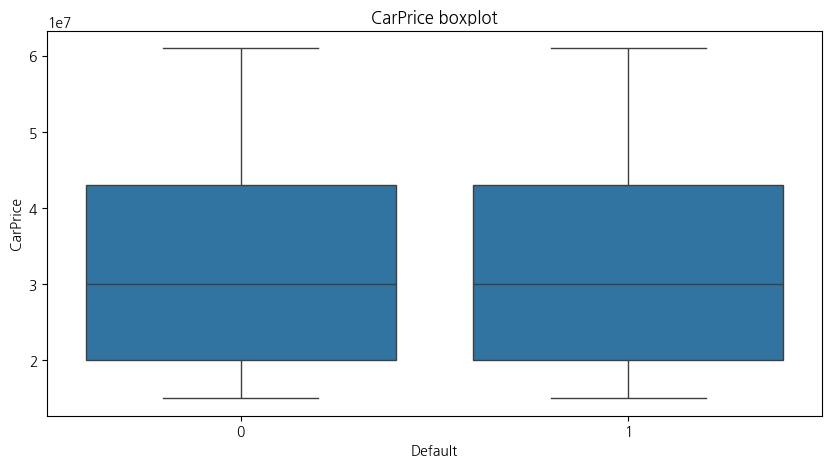

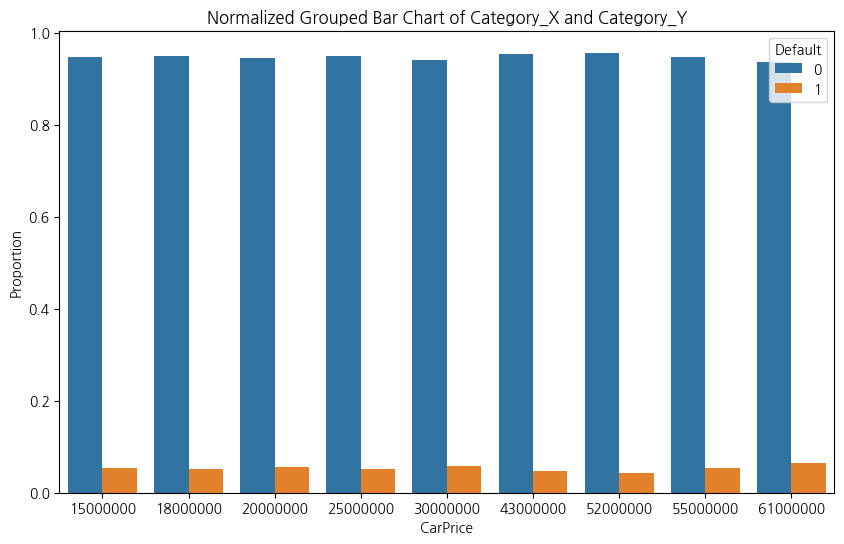

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['CarPrice', 'Default']).size() / df_em.groupby('CarPrice').size()

plt.figure(figsize = (10,5))
sns.boxplot( x = 'Default', y = 'CarPrice', data = df_em)
plt.title('CarPrice boxplot')

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='CarPrice', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')


Text(0.5, 1.0, 'Deposit hist')

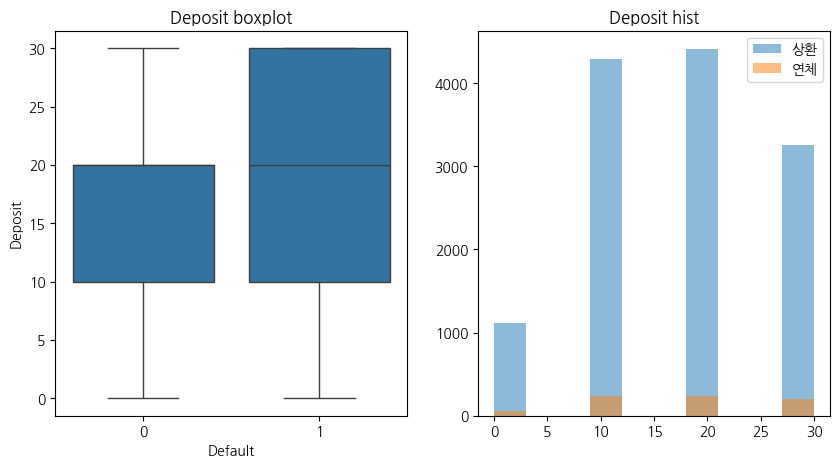

In [ ]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot( x = 'Default', y = 'Deposit', data = df_em)
plt.title('Deposit boxplot')

plt.subplot(1,2,2)
plt.hist(df_em[df_em['Default'] == 0]['Deposit'], label = '상환', alpha = 0.5)
plt.hist(df_em[df_em['Default'] == 1]['Deposit'] , label = '연체', alpha = 0.5)
plt.legend()
plt.title('Deposit hist')

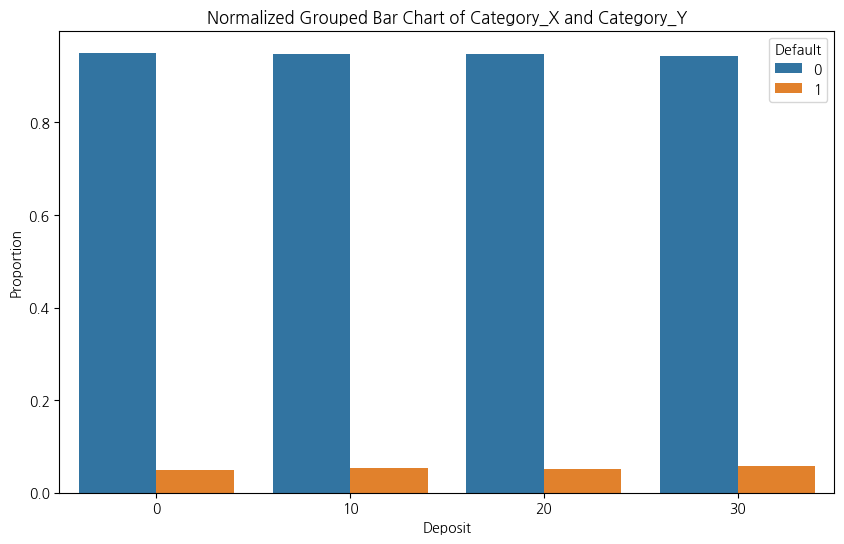

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Deposit', 'Default']).size() / df_em.groupby('Deposit').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Deposit', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

Text(0.5, 1.0, 'LoanRemainTerm hist')

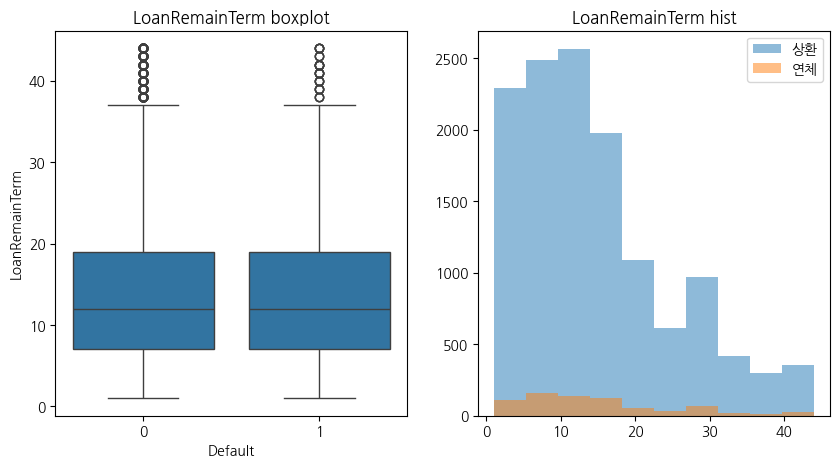

In [ ]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot( x = 'Default', y = 'LoanRemainTerm', data = df_em)
plt.title('LoanRemainTerm boxplot')

plt.subplot(1,2,2)
plt.hist(df_em[df_em['Default'] == 0]['LoanRemainTerm'], label = '상환', alpha = 0.5)
plt.hist(df_em[df_em['Default'] == 1]['LoanRemainTerm'] , label = '연체', alpha = 0.5)
plt.legend()
plt.title('LoanRemainTerm hist')

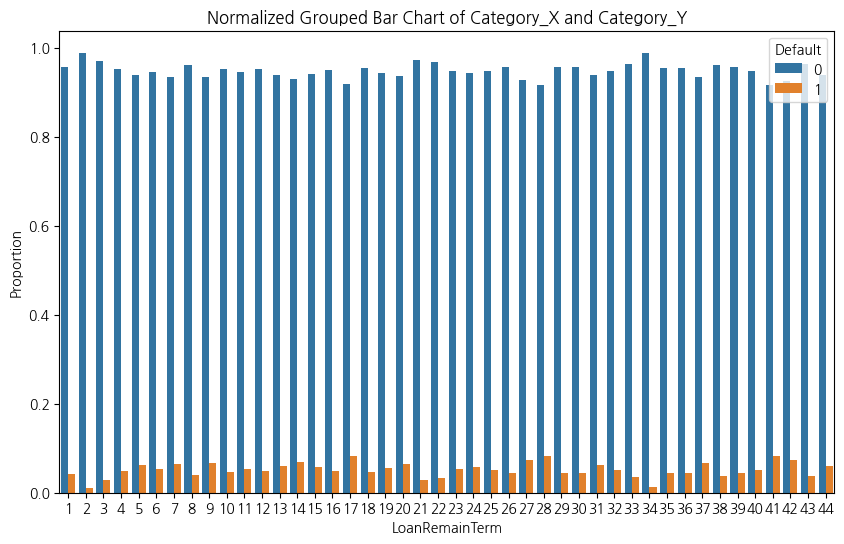

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['LoanRemainTerm', 'Default']).size() / df_em.groupby('LoanRemainTerm').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='LoanRemainTerm', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

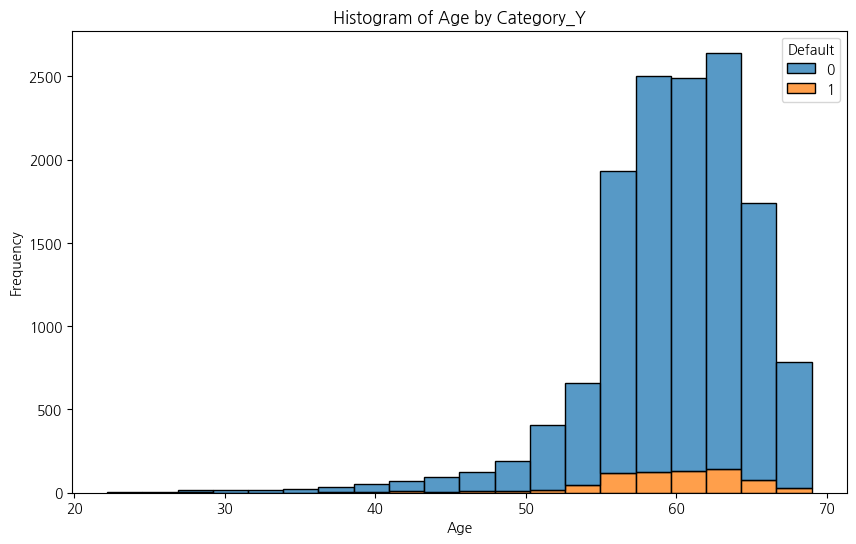

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='Age', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of Age by Category_Y')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

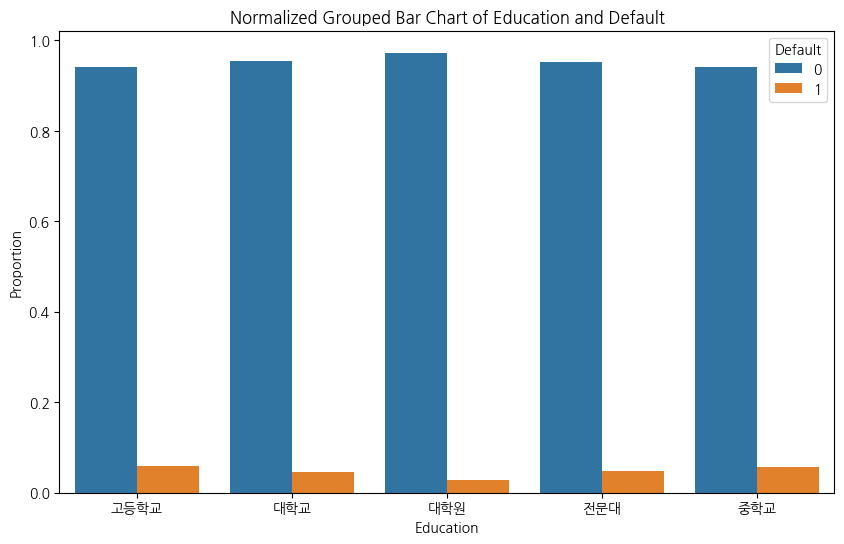

In [ ]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Education', 'Default']).size() / df_em.groupby('Education').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Education and Default')
plt.ylabel('Proportion')
plt.show()

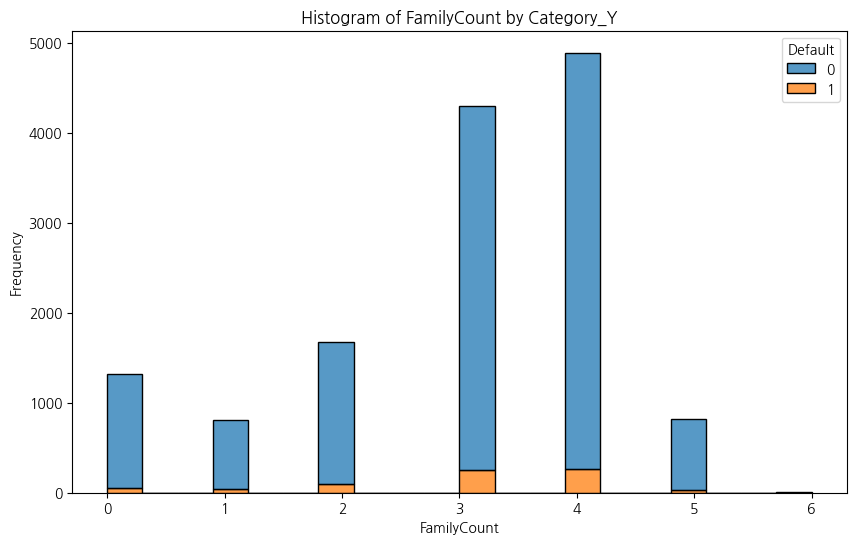

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='FamilyCount', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of FamilyCount by Category_Y')
plt.xlabel('FamilyCount')
plt.ylabel('Frequency')
plt.show()

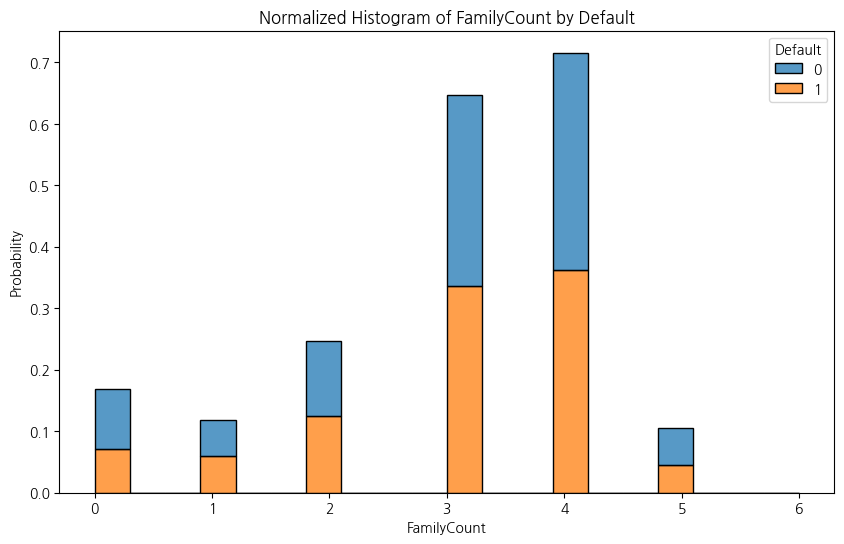

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='FamilyCount', hue='Default', multiple='stack', bins=20, stat='probability', common_norm=False)
plt.title('Normalized Histogram of FamilyCount by Default')
plt.xlabel('FamilyCount')
plt.ylabel('Probability')
plt.show()

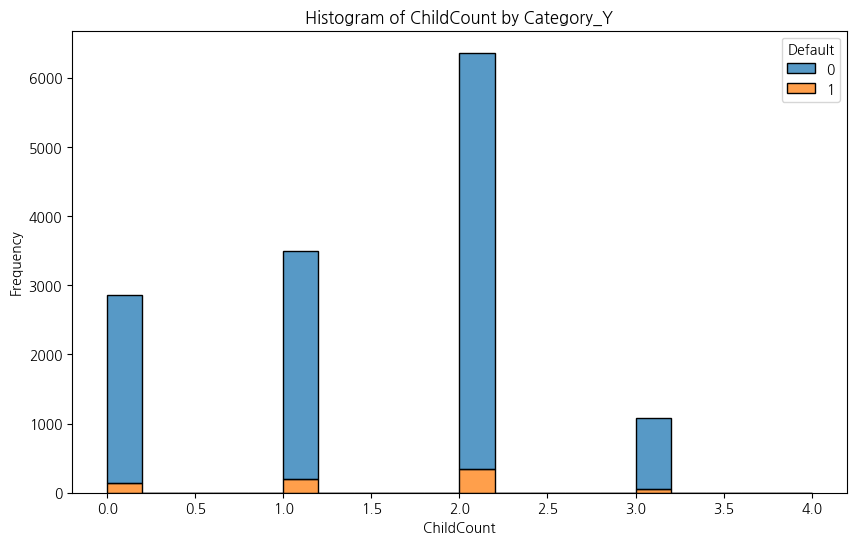

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='ChildCount', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of ChildCount by Category_Y')
plt.xlabel('ChildCount')
plt.ylabel('Frequency')
plt.show()

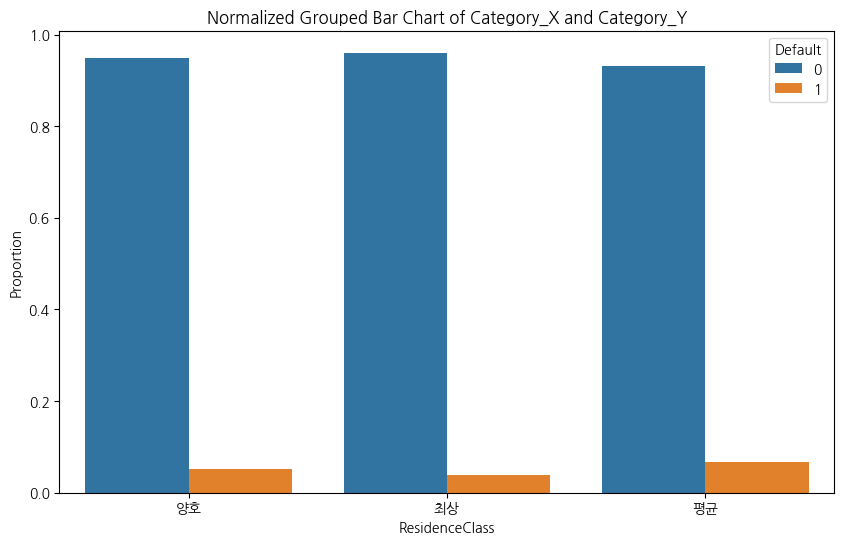

In [ ]:
normalized_counts = df_em.groupby(['ResidenceClass', 'Default']).size() / df_em.groupby('ResidenceClass').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='ResidenceClass', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

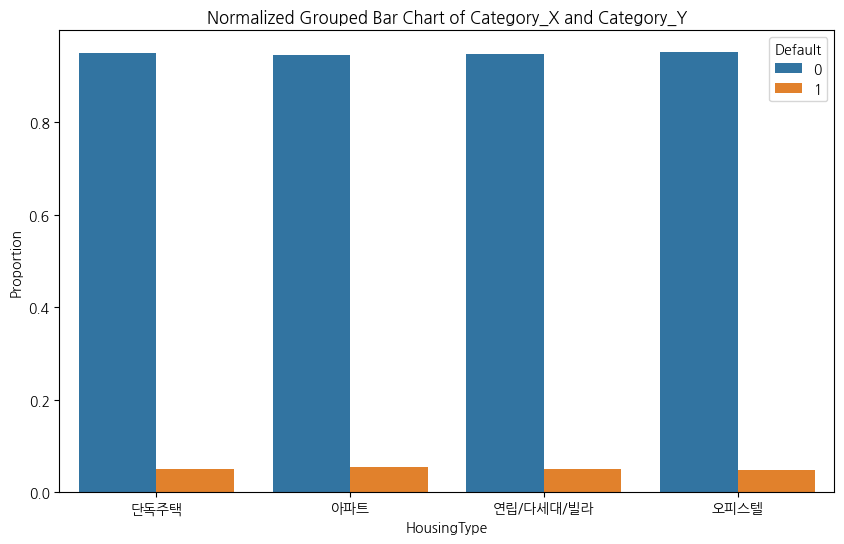

In [ ]:
normalized_counts = df_em.groupby(['HousingType', 'Default']).size() / df_em.groupby('HousingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='HousingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

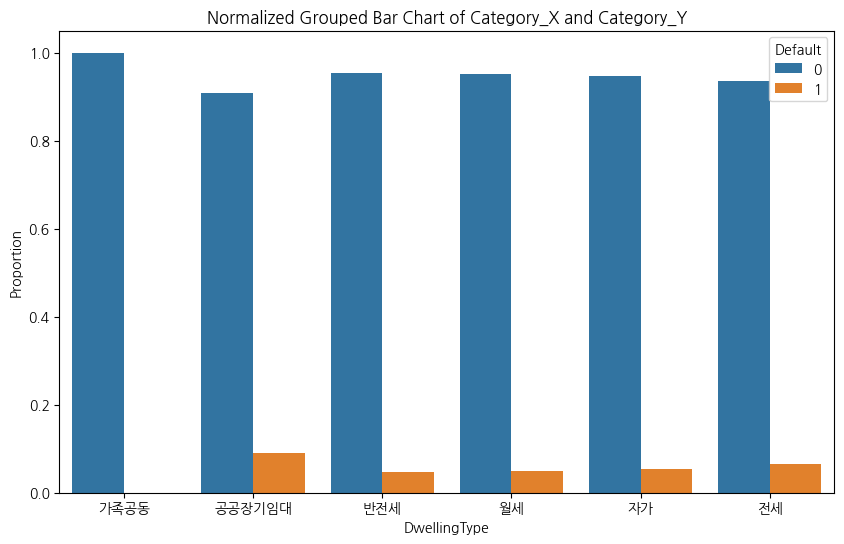

In [ ]:
normalized_counts = df_em.groupby(['DwellingType', 'Default']).size() / df_em.groupby('DwellingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='DwellingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

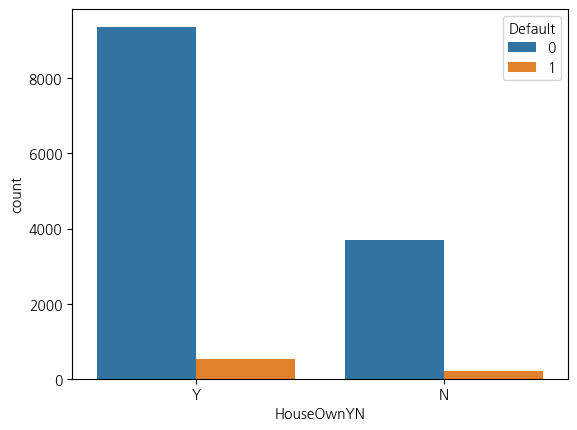

In [ ]:
sns.countplot(x='HouseOwnYN', hue='Default', data=df_em)
plt.show()

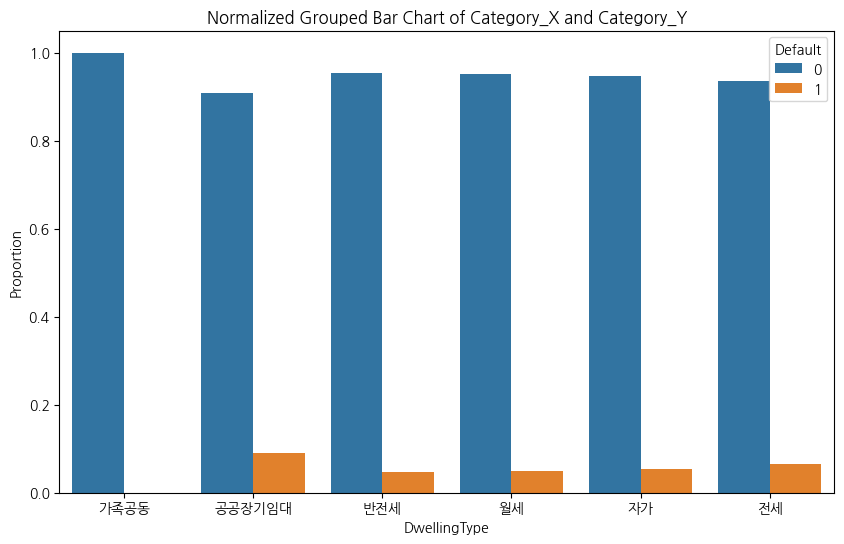

In [ ]:
normalized_counts = df_em.groupby(['DwellingType', 'Default']).size() / df_em.groupby('DwellingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='DwellingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

* EDA 결과 특이사항 없음 (각 항목에 따른 연체 여부 일정)

# 통계적 검정

## T검정

In [ ]:
from scipy.stats import ttest_ind

con_unsign = []
con_sign = []

# Default가 0인 그룹과 1인 그룹으로 나누기
group_0 = df_em[df_em['Default'] == 0]
group_1 = df_em[df_em['Default'] == 1]

# 수치형 변수 리스트 (수정이 필요하면 추가 또는 삭제)
numeric_cols = ['Age', 'FamilyCount', 'ChildCount','ApplHour', 'CarPrice',
                'Deposit', 'LoanTerm', 'LoanRemainTerm', 'InterestRate', 'LoanAmount', 'InstallAmount',
                'LoanRemainAmount', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']

# 수치형 변수들에 대한 t-검정 실행
for col in numeric_cols:
    t_stat, p_value = ttest_ind(group_0[col].dropna(), group_1[col].dropna(), equal_var=False)
#     print(f"{col} - t-statistic: {t_stat}, p-value: {p_value}")
    print(f"{col}")
    print('t-statistic: {0:0.3f}'.format(t_stat))
    print('p-value: {0:0.3f}'.format(p_value))
    print()

    #신뢰도 90%
    if p_value > 0.1 :
        con_unsign.append(col)
    else:
        con_sign.append(col)



# print("---------------------------------------------------------------------------------------------------------------------------------")
# print("")
# print("※ 신뢰도 90% 기반")
# print("")
# print("연체여부에 유의하지 않은 변수 {}".format(con_unsign))
# print("")
# print("연체여부에 유의한 변수 {}".format(con_sign))
# print("")


Age
t-statistic: 3.549
p-value: 0.000

FamilyCount
t-statistic: -0.950
p-value: 0.342

ChildCount
t-statistic: -0.360
p-value: 0.719

ApplHour
t-statistic: 0.345
p-value: 0.730

CarPrice
t-statistic: 0.173
p-value: 0.862

Deposit
t-statistic: -0.913
p-value: 0.362

LoanTerm
t-statistic: 0.719
p-value: 0.472

LoanRemainTerm
t-statistic: -0.630
p-value: 0.529

InterestRate
t-statistic: 1.904
p-value: 0.057

LoanAmount
t-statistic: 0.478
p-value: 0.633

InstallAmount
t-statistic: 0.277
p-value: 0.782

LoanRemainAmount
t-statistic: -0.771
p-value: 0.441

InquiryCount
t-statistic: -1.711
p-value: 0.087

IdChangedYears
t-statistic: 3.541
p-value: 0.000

InfoChangedYears
t-statistic: 1.941
p-value: 0.053

PhoneChangedYears
t-statistic: 5.419
p-value: 0.000



※ 신뢰도 90% 기반 연속형 변수 검정

연체여부에 유의하지 않은 변수 ['FamilyCount', 'ChildCount', 'ApplHour', 'CarPrice', 'Deposit', 'LoanTerm', 'LoanRemainTerm', 'LoanAmount', 'InstallAmount', 'LoanRemainAmount']

연체여부에 유의한 변수 ['Age', 'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']


## 카이제곱 검정

In [ ]:
from scipy.stats import chi2_contingency

cat_unsign = []
cat_sign = []
# 범주형 변수 추출
categorical_cols = df_em.select_dtypes(include=['object']).columns

# 카이제곱 검정 수행
for col in categorical_cols:
    cross_tab = pd.crosstab(df['Default'], df[col])
    chi, p_value, dof, expected = chi2_contingency(cross_tab)

    print(f"{col}:")
    print(f"chi-squared: {chi:.3f}")
    print(f"p-value: {p_value:.3f}")
    print(f"degree of freedom: {dof}")
    print()

    #신뢰도 90%
    if p_value > 0.1 :
        cat_unsign.append(col)
    else:
        cat_sign.append(col)


# print("---------------------------------------------------------------------------------------------------------------------------------")
# print("")
# print("※ 신뢰도 90% 기반")
# print("")
# print("연체여부에 유의하지 않은 변수 {}".format(cat_unsign))
# print("")
# print("연체여부에 유의한 변수 {}".format(cat_sign))
# print("")

Gender:
chi-squared: 135.131
p-value: 0.000
degree of freedom: 1

Education:
chi-squared: 289.541
p-value: 0.000
degree of freedom: 4

MaritalStatus:
chi-squared: 48.013
p-value: 0.000
degree of freedom: 3

IncomeClass:
chi-squared: 84.735
p-value: 0.000
degree of freedom: 7

OrgType:
chi-squared: 190.487
p-value: 0.000
degree of freedom: 18

HouseOwnYN:
chi-squared: 0.013
p-value: 0.908
degree of freedom: 1

DwellingType:
chi-squared: 46.642
p-value: 0.000
degree of freedom: 6

HousingType:
chi-squared: 0.696
p-value: 0.874
degree of freedom: 3

ResidenceClass:
chi-squared: 312.898
p-value: 0.000
degree of freedom: 3

CarOwnedYN:
chi-squared: 71.744
p-value: 0.000
degree of freedom: 1

ActiveLoanYN:
chi-squared: 10.450
p-value: 0.001
degree of freedom: 1

LoanType:
chi-squared: 64.510
p-value: 0.000
degree of freedom: 1

ApplWeek:
chi-squared: 8.245
p-value: 0.083
degree of freedom: 4

Accompany:
chi-squared: 7.778
p-value: 0.169
degree of freedom: 5

InterestType:
chi-squared: 134.92

※ 신뢰도 90% 기반 범주형 변수 검정

연체여부에 유의하지 않은 변수 ['HouseOwnYN', 'HousingType', 'Accompany']

연체여부에 유의한 변수 ['Gender', 'Education', 'MaritalStatus', 'IncomeClass', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'ApplWeek', 'InterestType', 'HomeAddMatchedYN']

## 최종 변수 선택

In [ ]:
sign = []
sign = cat_sign + con_sign
print(sign)

['Gender', 'Education', 'MaritalStatus', 'IncomeClass', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'ApplWeek', 'InterestType', 'HomeAddMatchedYN', 'Age', 'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']


In [ ]:
df_y = df_em["Default"]
df_x = df_em[sign]

* 연체 여부에 유의한 설명변수만 가지고 연체 예측

In [ ]:
df_x = pd.get_dummies(df_x)

In [ ]:
print(df_x.columns)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

Index(['Age', 'InterestRate', 'InquiryCount', 'IdChangedYears',
       'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성',
       'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대',
       'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신',
       'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상',
       'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만',
       'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만',
       'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만',
       'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스',
       'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동',
       'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세',
       'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호',
       'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N',
       'CarOwnedYN_Y', 'ActiveLoanYN_N', 'ActiveLoanYN_Y', 'LoanType_오토론',
       'LoanType_할부금융

## SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE
# # 목표변수 빈도 확인
# print(df_em.value_counts(["Default"]),"\n")
# print("Defalut=1 비율  ", df_em.value_counts(df_em["Default"]==1)/len(df_em))

In [ ]:
# # Over-sampling 설정
# sm = SMOTE(sampling_strategy='auto')

# # train데이터를 이용한 Over-sampling
# x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# # 결과 확인
# print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
# print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
# print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

# print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
# print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

In [ ]:
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(x_resampled, y_resampled, test_size = 0.3)

# print("train data X size : {}".format(df_train_x.shape))
# print("train data Y size : {}".format(df_train_y.shape))
# print("test data X size : {}".format(df_test_x.shape))
# print("test data Y size : {}".format(df_test_y.shape))

* 목표변수인 Default가 불균형 데이터(정상 93%, 연체 7%)로 구성되어 있기 때문에 SMOTE 기법을 활용하여 이를 해소하고자 함.

  - SMOTE 적용 전 F1 Score : 0.04
  - SMOTE 적용 후 F1 Score : 0.95

## GB

In [ ]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier()
gb_uncust.fit(df_train_x, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x, df_test_y)))

Accuracy on training set: 0.950
Accuracy on test set: 0.944


In [ ]:
# 실행옵션 확인
print(gb_uncust.get_params().keys())
print(gb_uncust.get_params().values())

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
dict_values([0.0, 'friedman_mse', None, 0.1, 'log_loss', 3, None, None, 0.0, 1, 2, 0.0, 100, None, None, 1.0, 0.0001, 0.1, 0, False])


In [ ]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf=15, max_depth=6, n_estimators=100, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.961
Test Accuracy: 0.945

Test Confusion matrix: 
[[3910    2]
 [ 226    4]]
              precision    recall  f1-score   support

           0      0.945     0.999     0.972      3912
           1      0.667     0.017     0.034       230

    accuracy                          0.945      4142
   macro avg      0.806     0.508     0.503      4142
weighted avg      0.930     0.945     0.920      4142



In [ ]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
4,InfoChangedYears,0.170
0,Age,0.162
3,IdChangedYears,0.138
5,PhoneChangedYears,0.126
1,InterestRate,0.055
2,InquiryCount,0.044
28,OrgType_서비스,0.015
8,Education_고등학교,0.014
51,ApplWeek_화,0.014
52,InterestType_고정,0.013


Text(0, 0.5, '설명변수')

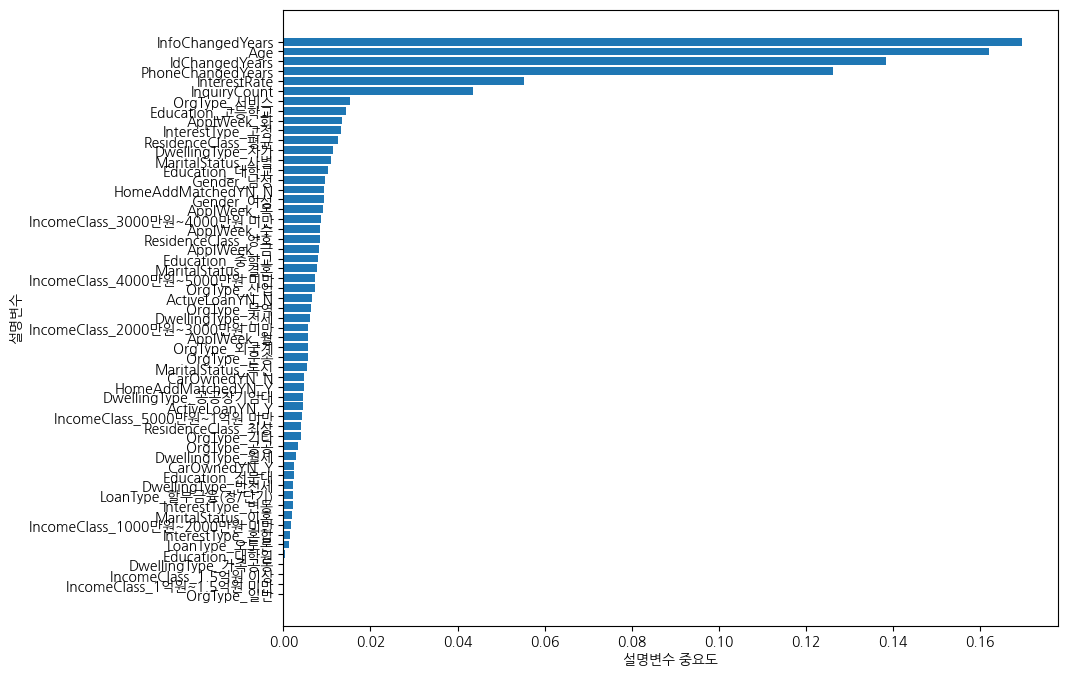

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## XGBoost

In [ ]:
# xgboost 패키지 불러오기
from xgboost import XGBClassifier

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [ ]:
# 기본 모델 지정 및 기본 옵션 확인
xgboost_uncust = XGBClassifier()

xgboost_uncust
# xgboost_uncust.get_params()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# 모델 적합
xgboost_uncust.fit(df_train_x, df_train_y)

print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
xgb_pred_train = xgboost_uncust.predict(df_train_x)
# 모델 평가
eval_class_model(df_train_y, xgb_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
xgb_pred_test = xgboost_uncust.predict(df_test_x)
# 모델 평가
eval_class_model(df_test_y, xgb_pred_test)


 모델 생성 및 평가 : Train 

오차행렬:
 [[9157    0]
 [ 100  407]] 

정확도: 0.9897
정밀도: 1.0000
재현율: 0.8028
F1    : 0.8906
AUC   : 0.9014

 모델 생성 및 평가 : Test 

오차행렬:
 [[3903    9]
 [ 224    6]] 

정확도: 0.9437
정밀도: 0.4000
재현율: 0.0261
F1    : 0.0490
AUC   : 0.5119


In [ ]:
# sklearn XGBoost 모델의 조기 중단:fit( )에 파라미터 입력(early_stopping_rounds, eval_metrics, eval_set.)
# 모델 파라미터 지정:n_estimators, learning_rate, max_depth 등 지정
# 조기 중간 파라미터 지정: early_stopping_rounds
# 평가지표 지정:logloss

# 모델 성능 평가 데이터
eval_df = [(df_test_x, df_test_y)]

xgb_stop = XGBClassifier(n_estimators = 300, learning_rate = 0.1 , max_depth = 6)
xgb_stop.fit(df_train_x, df_train_y,
            # 조기 중단 파라미터
             early_stopping_rounds = 150, eval_metric="logloss", eval_set = eval_df, verbose=True)

[0]	validation_0-logloss:0.24700
[1]	validation_0-logloss:0.24150
[2]	validation_0-logloss:0.23675
[3]	validation_0-logloss:0.23282
[4]	validation_0-logloss:0.22952
[5]	validation_0-logloss:0.22622
[6]	validation_0-logloss:0.22372
[7]	validation_0-logloss:0.22151
[8]	validation_0-logloss:0.21957
[9]	validation_0-logloss:0.21791
[10]	validation_0-logloss:0.21664
[11]	validation_0-logloss:0.21554
[12]	validation_0-logloss:0.21448
[13]	validation_0-logloss:0.21355
[14]	validation_0-logloss:0.21292
[15]	validation_0-logloss:0.21208


/home/piai/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/piai/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.21170
[17]	validation_0-logloss:0.21120
[18]	validation_0-logloss:0.21045
[19]	validation_0-logloss:0.21014
[20]	validation_0-logloss:0.21013
[21]	validation_0-logloss:0.20998
[22]	validation_0-logloss:0.20971
[23]	validation_0-logloss:0.20935
[24]	validation_0-logloss:0.20949
[25]	validation_0-logloss:0.20936
[26]	validation_0-logloss:0.20935
[27]	validation_0-logloss:0.20928
[28]	validation_0-logloss:0.20913
[29]	validation_0-logloss:0.20907
[30]	validation_0-logloss:0.20873
[31]	validation_0-logloss:0.20905
[32]	validation_0-logloss:0.20910
[33]	validation_0-logloss:0.20903
[34]	validation_0-logloss:0.20920
[35]	validation_0-logloss:0.20937
[36]	validation_0-logloss:0.20939
[37]	validation_0-logloss:0.20931
[38]	validation_0-logloss:0.20935
[39]	validation_0-logloss:0.20908
[40]	validation_0-logloss:0.20923
[41]	validation_0-logloss:0.20943
[42]	validation_0-logloss:0.20929
[43]	validation_0-logloss:0.20922
[44]	validation_0-logloss:0.20920
[45]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# 최적 모델 정보 확인
print("최적 횟수:",xgb_stop.best_iteration)
print("최적 성능(0-LogLoss):",xgb_stop.best_score)

최적 횟수: 30
최적 성능(0-LogLoss): 0.20872822332765703


{'Age': 841.0, 'InterestRate': 408.0, 'InquiryCount': 339.0, 'IdChangedYears': 760.0, 'InfoChangedYears': 925.0, 'PhoneChangedYears': 685.0, 'Gender_남성': 56.0, 'Education_고등학교': 93.0, 'Education_대학교': 41.0, 'Education_대학원': 18.0, 'Education_전문대': 36.0, 'Education_중학교': 41.0, 'MaritalStatus_결혼': 56.0, 'MaritalStatus_독신': 31.0, 'MaritalStatus_사별': 70.0, 'MaritalStatus_이혼': 14.0, 'IncomeClass_1000만원~2000만원 미만': 5.0, 'IncomeClass_1억원~1.5억원 미만': 8.0, 'IncomeClass_2000만원~3000만원 미만': 17.0, 'IncomeClass_3000만원~4000만원 미만': 48.0, 'IncomeClass_4000만원~5000만원 미만': 46.0, 'IncomeClass_5000만원~1억원 미만': 18.0, 'OrgType_공공': 17.0, 'OrgType_기타': 31.0, 'OrgType_무역': 43.0, 'OrgType_산업': 59.0, 'OrgType_서비스': 78.0, 'OrgType_외국계': 25.0, 'OrgType_운송': 36.0, 'DwellingType_공공장기임대': 11.0, 'DwellingType_반전세': 34.0, 'DwellingType_월세': 43.0, 'DwellingType_자가': 73.0, 'DwellingType_전세': 32.0, 'ResidenceClass_양호': 48.0, 'ResidenceClass_최상': 21.0, 'ResidenceClass_평균': 57.0, 'CarOwnedYN_N': 66.0, 'ActiveLoanYN_N': 81.0, 'L

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

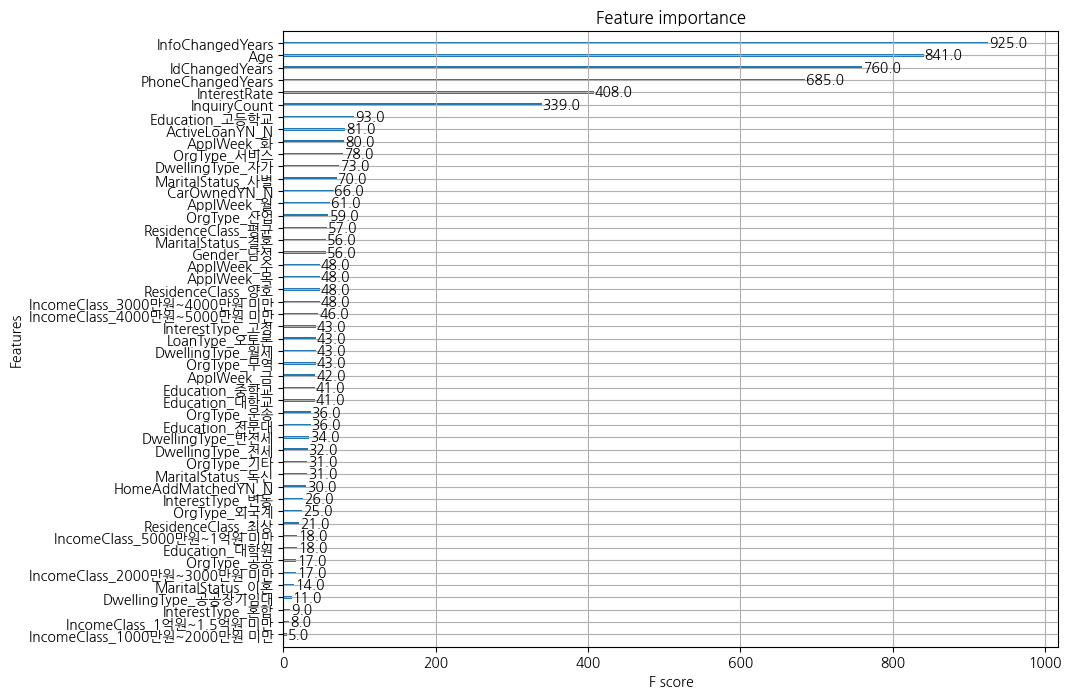

In [ ]:
# 변수 중요도 확인
from xgboost import plot_importance  # F1 score 기준으로 변수 중요도 표시(변경 가능)
print(xgb_stop.get_booster().get_fscore())
""
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_stop, ax=ax)

## LightGBM

In [ ]:
# LightGBM 패키지 불러오기
from lightgbm import LGBMClassifier

# 변수 중요도 확인: F1 점수 기준
from lightgbm import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [ ]:
# 기본 모델 지정 및 기본 옵션 확인
lgbm_uncust = LGBMClassifier()

lgbm_uncust.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
# 모델 적합
lgbm_uncust.fit(df_train_x, df_train_y)
print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
lgbm_pred_train = lgbm_uncust.predict(df_train_x)
eval_class_model(df_train_y, lgbm_pred_train)
print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
lgbm_pred_test = lgbm_uncust.predict(df_test_x)
eval_class_model(df_test_y, lgbm_pred_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 507, number of negative: 9157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 9664, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052463 -> initscore=-2.893763
[LightGBM] [Info] Start training from score -2.893763

 모델 생성 및 평가 : Train 

오차행렬:
 [[9157    0]
 [ 352  155]] 

정확도: 0.9636
정밀도: 1.0000
재현율: 0.3057
F1    : 0.4683
AUC   : 0.6529

 모델 생성 및 평가 : Test 

오차행렬:
 [[3911    1]
 [ 228    2]] 

정확도: 0.9447
정밀도: 0.6667
재현율: 0.0087
F1    : 0.0172
AUC   : 0.5042


In [ ]:
# 사용자 모델 생성
lgbm_user= LGBMClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 6)
# 모델 적합
lgbm_user.fit(df_train_x, df_train_y)

# 예측 및 모델 평가:Train
lgbm_pred_train = lgbm_user.predict(df_train_x)

eval_class_model(df_train_y, lgbm_pred_train)
print('\n',classification_report(df_train_y, lgbm_pred_train))

# 예측 및 모델 평가:Test
lgbm_pred_test = lgbm_user.predict(df_test_x)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, lgbm_pred_test)
print('\n',classification_report(df_test_y, lgbm_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 507, number of negative: 9157
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 9664, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052463 -> initscore=-2.893763
[LightGBM] [Info] Start training from score -2.893763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

['Age', 'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원_이상', 'IncomeClass_1000만원~2000만원_미만', 'IncomeClass_1억원~1.5억원_미만', 'IncomeClass_2000만원~3000만원_미만', 'IncomeClass_3000만원~4000만원_미만', 'IncomeClass_4000만원~5000만원_미만', 'IncomeClass_5000만원~1억원_미만', 'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동', 'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호', 'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N', 'CarOwnedYN_Y', 'ActiveLoanYN_N', 'ActiveLoanYN_Y', 'LoanType_오토론', 'LoanType_할부금융(장/단기)', 'ApplWeek_금', 'ApplWeek_목', 'ApplWeek_수', 'ApplWeek_월', 'ApplWeek_화', 'InterestType_고정', 'Inter

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

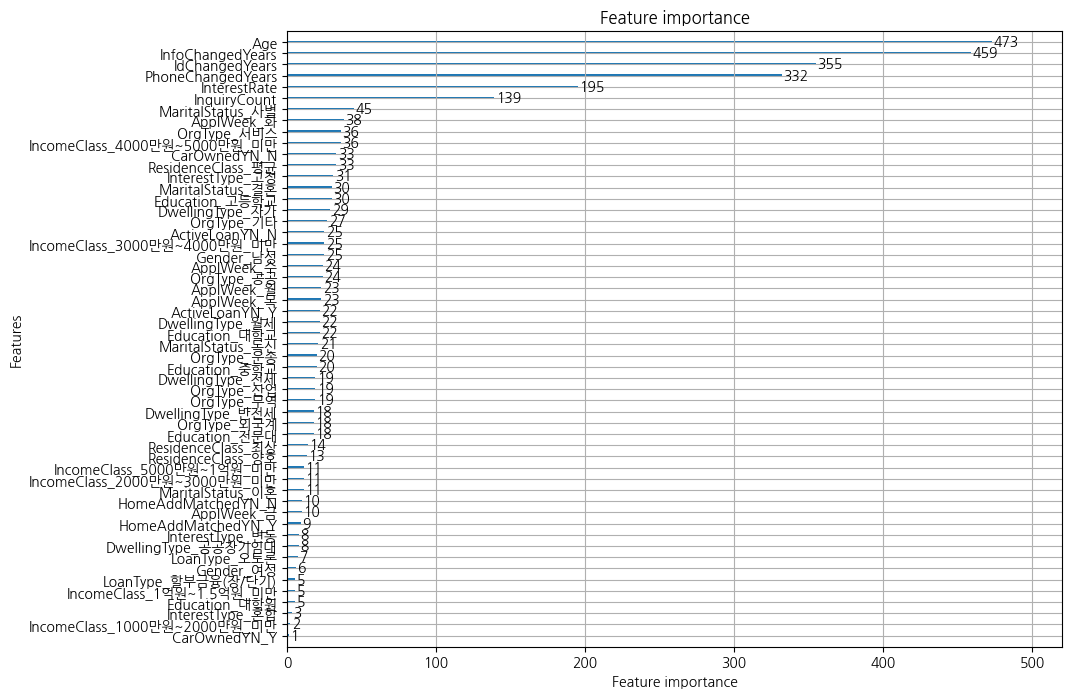

In [ ]:
# 변수 중요도 확인
from lightgbm import plot_importance
print(lgbm_user.feature_name_)
print(lgbm_user.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(lgbm_user, ax=ax)

## CatBoost

In [ ]:
# 패키지 불러오기
from catboost import CatBoostClassifier

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [ ]:
# 기본 모델 지정 및 기본 옵션 확인
cbc_uncust = CatBoostClassifier()

cbc_uncust.get_all_params

<bound method CatBoost.get_all_params of <catboost.core.CatBoostClassifier object at 0x7f46c62cf760>>

In [ ]:
# 모델 적합
cbc_uncust.fit(df_train_x, df_train_y)

print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
cbc_pred_train = cbc_uncust.predict(df_train_x)
eval_class_model(df_train_y, cbc_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
cbc_pred_test = cbc_uncust.predict(df_test_x)
eval_class_model(df_test_y, cbc_pred_test)

Learning rate set to 0.027139
0:	learn: 0.6581928	total: 55.3ms	remaining: 55.3s
1:	learn: 0.6258624	total: 62.5ms	remaining: 31.2s
2:	learn: 0.5956025	total: 68.3ms	remaining: 22.7s
3:	learn: 0.5678289	total: 73ms	remaining: 18.2s
4:	learn: 0.5420571	total: 77.5ms	remaining: 15.4s
5:	learn: 0.5180636	total: 81.9ms	remaining: 13.6s
6:	learn: 0.4956375	total: 86.1ms	remaining: 12.2s
7:	learn: 0.4749564	total: 90.4ms	remaining: 11.2s
8:	learn: 0.4558522	total: 94.6ms	remaining: 10.4s
9:	learn: 0.4378468	total: 99.1ms	remaining: 9.81s
10:	learn: 0.4216116	total: 103ms	remaining: 9.28s
11:	learn: 0.4065193	total: 107ms	remaining: 8.84s
12:	learn: 0.3925785	total: 110ms	remaining: 8.38s
13:	learn: 0.3793476	total: 114ms	remaining: 8.06s
14:	learn: 0.3671591	total: 119ms	remaining: 7.79s
15:	learn: 0.3558306	total: 123ms	remaining: 7.54s
16:	learn: 0.3453646	total: 127ms	remaining: 7.32s
17:	learn: 0.3356136	total: 130ms	remaining: 7.11s
18:	learn: 0.3263405	total: 134ms	remaining: 6.93s
19:

160:	learn: 0.1823281	total: 596ms	remaining: 3.11s
161:	learn: 0.1822337	total: 600ms	remaining: 3.1s
162:	learn: 0.1820873	total: 603ms	remaining: 3.09s
163:	learn: 0.1820011	total: 606ms	remaining: 3.09s
164:	learn: 0.1818688	total: 609ms	remaining: 3.08s
165:	learn: 0.1817424	total: 612ms	remaining: 3.08s
166:	learn: 0.1815645	total: 615ms	remaining: 3.07s
167:	learn: 0.1813818	total: 618ms	remaining: 3.06s
168:	learn: 0.1812249	total: 622ms	remaining: 3.06s
169:	learn: 0.1810330	total: 625ms	remaining: 3.05s
170:	learn: 0.1809393	total: 628ms	remaining: 3.04s
171:	learn: 0.1808215	total: 631ms	remaining: 3.04s
172:	learn: 0.1806043	total: 634ms	remaining: 3.03s
173:	learn: 0.1804845	total: 637ms	remaining: 3.02s
174:	learn: 0.1803740	total: 641ms	remaining: 3.02s
175:	learn: 0.1801863	total: 644ms	remaining: 3.01s
176:	learn: 0.1801233	total: 647ms	remaining: 3.01s
177:	learn: 0.1799766	total: 650ms	remaining: 3s
178:	learn: 0.1797836	total: 653ms	remaining: 3s
179:	learn: 0.17963

347:	learn: 0.1609144	total: 1.19s	remaining: 2.23s
348:	learn: 0.1608309	total: 1.19s	remaining: 2.23s
349:	learn: 0.1607233	total: 1.2s	remaining: 2.22s
350:	learn: 0.1606019	total: 1.2s	remaining: 2.22s
351:	learn: 0.1604776	total: 1.2s	remaining: 2.22s
352:	learn: 0.1603497	total: 1.21s	remaining: 2.21s
353:	learn: 0.1602272	total: 1.21s	remaining: 2.21s
354:	learn: 0.1600963	total: 1.21s	remaining: 2.21s
355:	learn: 0.1600586	total: 1.22s	remaining: 2.2s
356:	learn: 0.1599440	total: 1.22s	remaining: 2.2s
357:	learn: 0.1598756	total: 1.22s	remaining: 2.19s
358:	learn: 0.1597975	total: 1.23s	remaining: 2.19s
359:	learn: 0.1597438	total: 1.23s	remaining: 2.19s
360:	learn: 0.1596043	total: 1.23s	remaining: 2.18s
361:	learn: 0.1594730	total: 1.24s	remaining: 2.18s
362:	learn: 0.1593264	total: 1.24s	remaining: 2.17s
363:	learn: 0.1592595	total: 1.24s	remaining: 2.17s
364:	learn: 0.1592058	total: 1.25s	remaining: 2.17s
365:	learn: 0.1591385	total: 1.25s	remaining: 2.16s
366:	learn: 0.158

532:	learn: 0.1428015	total: 1.79s	remaining: 1.56s
533:	learn: 0.1427717	total: 1.79s	remaining: 1.56s
534:	learn: 0.1426944	total: 1.79s	remaining: 1.56s
535:	learn: 0.1426194	total: 1.8s	remaining: 1.55s
536:	learn: 0.1425244	total: 1.8s	remaining: 1.55s
537:	learn: 0.1425004	total: 1.8s	remaining: 1.55s
538:	learn: 0.1424027	total: 1.81s	remaining: 1.54s
539:	learn: 0.1423773	total: 1.81s	remaining: 1.54s
540:	learn: 0.1422532	total: 1.81s	remaining: 1.54s
541:	learn: 0.1420531	total: 1.81s	remaining: 1.53s
542:	learn: 0.1419223	total: 1.82s	remaining: 1.53s
543:	learn: 0.1418708	total: 1.82s	remaining: 1.53s
544:	learn: 0.1417476	total: 1.82s	remaining: 1.52s
545:	learn: 0.1416519	total: 1.83s	remaining: 1.52s
546:	learn: 0.1415403	total: 1.83s	remaining: 1.52s
547:	learn: 0.1414732	total: 1.83s	remaining: 1.51s
548:	learn: 0.1413749	total: 1.84s	remaining: 1.51s
549:	learn: 0.1412789	total: 1.84s	remaining: 1.51s
550:	learn: 0.1412355	total: 1.84s	remaining: 1.5s
551:	learn: 0.14

717:	learn: 0.1291744	total: 2.38s	remaining: 935ms
718:	learn: 0.1291204	total: 2.38s	remaining: 932ms
719:	learn: 0.1290416	total: 2.39s	remaining: 929ms
720:	learn: 0.1289459	total: 2.39s	remaining: 925ms
721:	learn: 0.1288224	total: 2.39s	remaining: 922ms
722:	learn: 0.1287239	total: 2.4s	remaining: 918ms
723:	learn: 0.1286499	total: 2.4s	remaining: 915ms
724:	learn: 0.1285850	total: 2.4s	remaining: 912ms
725:	learn: 0.1285288	total: 2.41s	remaining: 908ms
726:	learn: 0.1284453	total: 2.41s	remaining: 905ms
727:	learn: 0.1283853	total: 2.41s	remaining: 901ms
728:	learn: 0.1283565	total: 2.42s	remaining: 898ms
729:	learn: 0.1282918	total: 2.42s	remaining: 895ms
730:	learn: 0.1282128	total: 2.42s	remaining: 891ms
731:	learn: 0.1281400	total: 2.42s	remaining: 888ms
732:	learn: 0.1280568	total: 2.43s	remaining: 885ms
733:	learn: 0.1279792	total: 2.43s	remaining: 881ms
734:	learn: 0.1279370	total: 2.43s	remaining: 878ms
735:	learn: 0.1279041	total: 2.44s	remaining: 875ms
736:	learn: 0.1

902:	learn: 0.1167025	total: 2.98s	remaining: 320ms
903:	learn: 0.1166498	total: 2.98s	remaining: 316ms
904:	learn: 0.1166040	total: 2.98s	remaining: 313ms
905:	learn: 0.1165194	total: 2.99s	remaining: 310ms
906:	learn: 0.1164581	total: 2.99s	remaining: 307ms
907:	learn: 0.1163811	total: 2.99s	remaining: 303ms
908:	learn: 0.1163019	total: 3s	remaining: 300ms
909:	learn: 0.1162086	total: 3s	remaining: 297ms
910:	learn: 0.1161228	total: 3s	remaining: 293ms
911:	learn: 0.1160237	total: 3.01s	remaining: 290ms
912:	learn: 0.1159110	total: 3.01s	remaining: 287ms
913:	learn: 0.1158376	total: 3.01s	remaining: 283ms
914:	learn: 0.1157739	total: 3.02s	remaining: 280ms
915:	learn: 0.1156830	total: 3.02s	remaining: 277ms
916:	learn: 0.1156534	total: 3.02s	remaining: 274ms
917:	learn: 0.1155365	total: 3.03s	remaining: 270ms
918:	learn: 0.1154811	total: 3.03s	remaining: 267ms
919:	learn: 0.1154452	total: 3.03s	remaining: 264ms
920:	learn: 0.1153676	total: 3.04s	remaining: 260ms
921:	learn: 0.1152562

In [ ]:
# 사용자 모델 생성
cbc_user= CatBoostClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 7)
# 모델 적합
cbc_user.fit(df_train_x, df_train_y)

# 예측 및 모델 평가:Train
cbc_pred_train = cbc_user.predict(df_train_x)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, cbc_pred_train)
print('\n',classification_report(df_train_y, cbc_pred_train))


# 예측 및 모델 평가:Test
cbc_pred_test = cbc_user.predict(df_test_x)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, cbc_pred_test)
print('\n',classification_report(df_test_y, cbc_pred_test))

0:	learn: 0.5719753	total: 5.92ms	remaining: 1.18s
1:	learn: 0.4816877	total: 12ms	remaining: 1.18s
2:	learn: 0.4131855	total: 15.7ms	remaining: 1.03s
3:	learn: 0.3619292	total: 22.5ms	remaining: 1.1s
4:	learn: 0.3246557	total: 25.4ms	remaining: 991ms
5:	learn: 0.2954663	total: 31.4ms	remaining: 1.01s
6:	learn: 0.2741500	total: 34.9ms	remaining: 962ms
7:	learn: 0.2572217	total: 40.4ms	remaining: 969ms
8:	learn: 0.2441348	total: 46ms	remaining: 975ms
9:	learn: 0.2339424	total: 51.8ms	remaining: 983ms
10:	learn: 0.2256032	total: 58.6ms	remaining: 1.01s
11:	learn: 0.2200518	total: 61.5ms	remaining: 964ms
12:	learn: 0.2151266	total: 67.2ms	remaining: 966ms
13:	learn: 0.2108810	total: 72.8ms	remaining: 968ms
14:	learn: 0.2071657	total: 78.6ms	remaining: 969ms
15:	learn: 0.2041494	total: 84.4ms	remaining: 971ms
16:	learn: 0.2013834	total: 90.1ms	remaining: 970ms
17:	learn: 0.1998683	total: 96ms	remaining: 971ms
18:	learn: 0.1979537	total: 102ms	remaining: 969ms
19:	learn: 0.1961380	total: 10

169:	learn: 0.1152843	total: 988ms	remaining: 174ms
170:	learn: 0.1151055	total: 995ms	remaining: 169ms
171:	learn: 0.1147933	total: 1s	remaining: 163ms
172:	learn: 0.1142170	total: 1.01s	remaining: 157ms
173:	learn: 0.1137482	total: 1.01s	remaining: 151ms
174:	learn: 0.1136804	total: 1.02s	remaining: 145ms
175:	learn: 0.1131696	total: 1.02s	remaining: 140ms
176:	learn: 0.1128928	total: 1.03s	remaining: 134ms
177:	learn: 0.1126750	total: 1.04s	remaining: 128ms
178:	learn: 0.1123100	total: 1.04s	remaining: 122ms
179:	learn: 0.1119710	total: 1.05s	remaining: 116ms
180:	learn: 0.1117353	total: 1.05s	remaining: 111ms
181:	learn: 0.1114044	total: 1.06s	remaining: 105ms
182:	learn: 0.1112601	total: 1.06s	remaining: 99ms
183:	learn: 0.1110569	total: 1.07s	remaining: 93.2ms
184:	learn: 0.1107981	total: 1.08s	remaining: 87.4ms
185:	learn: 0.1106574	total: 1.08s	remaining: 81.5ms
186:	learn: 0.1104287	total: 1.09s	remaining: 75.7ms
187:	learn: 0.1099831	total: 1.09s	remaining: 69.9ms
188:	learn:

/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklea

In [ ]:
# 모델 성능 평가 데이터
eval_df = [(df_test_x, df_test_y)]

cbc_stop = CatBoostClassifier(n_estimators = 300, learning_rate = 0.1 , max_depth = 6)

cbc_stop.fit(df_train_x, df_train_y,
            # 조기 중단 파라미터
             early_stopping_rounds = 150,eval_set = eval_df, verbose=True)
# cbc_stop.fit(df_train_x, df_train_y,
#             # 조기 중단 파라미터
#              early_stopping_rounds = 150, eval_metric="auto", eval_set = eval_df,
#              verbose=True)

0:	learn: 0.5723174	test: 0.5731898	best: 0.5731898 (0)	total: 4.7ms	remaining: 1.41s
1:	learn: 0.4819495	test: 0.4839255	best: 0.4839255 (1)	total: 9.64ms	remaining: 1.44s
2:	learn: 0.4136062	test: 0.4166189	best: 0.4166189 (2)	total: 14.3ms	remaining: 1.41s
3:	learn: 0.3617457	test: 0.3659395	best: 0.3659395 (3)	total: 18.8ms	remaining: 1.39s
4:	learn: 0.3240550	test: 0.3291603	best: 0.3291603 (4)	total: 23.5ms	remaining: 1.39s
5:	learn: 0.2951188	test: 0.3013490	best: 0.3013490 (5)	total: 28.1ms	remaining: 1.37s
6:	learn: 0.2731773	test: 0.2800528	best: 0.2800528 (6)	total: 32.5ms	remaining: 1.36s
7:	learn: 0.2563381	test: 0.2640502	best: 0.2640502 (7)	total: 37ms	remaining: 1.35s
8:	learn: 0.2437924	test: 0.2521252	best: 0.2521252 (8)	total: 41.5ms	remaining: 1.34s
9:	learn: 0.2335795	test: 0.2427852	best: 0.2427852 (9)	total: 46ms	remaining: 1.33s
10:	learn: 0.2260209	test: 0.2358796	best: 0.2358796 (10)	total: 50.6ms	remaining: 1.33s
11:	learn: 0.2200518	test: 0.2305995	best: 0.2

116:	learn: 0.1518853	test: 0.2092570	best: 0.2078244 (80)	total: 533ms	remaining: 833ms
117:	learn: 0.1515839	test: 0.2094208	best: 0.2078244 (80)	total: 537ms	remaining: 829ms
118:	learn: 0.1514182	test: 0.2093922	best: 0.2078244 (80)	total: 542ms	remaining: 824ms
119:	learn: 0.1510148	test: 0.2092869	best: 0.2078244 (80)	total: 547ms	remaining: 820ms
120:	learn: 0.1508276	test: 0.2093370	best: 0.2078244 (80)	total: 551ms	remaining: 815ms
121:	learn: 0.1505954	test: 0.2094256	best: 0.2078244 (80)	total: 556ms	remaining: 811ms
122:	learn: 0.1502134	test: 0.2094828	best: 0.2078244 (80)	total: 560ms	remaining: 806ms
123:	learn: 0.1499854	test: 0.2094164	best: 0.2078244 (80)	total: 565ms	remaining: 802ms
124:	learn: 0.1497146	test: 0.2095331	best: 0.2078244 (80)	total: 569ms	remaining: 797ms
125:	learn: 0.1495489	test: 0.2094488	best: 0.2078244 (80)	total: 574ms	remaining: 793ms
126:	learn: 0.1492247	test: 0.2096843	best: 0.2078244 (80)	total: 579ms	remaining: 788ms
127:	learn: 0.1488047

224:	learn: 0.1204261	test: 0.2126578	best: 0.2078244 (80)	total: 1.01s	remaining: 336ms
225:	learn: 0.1201020	test: 0.2125914	best: 0.2078244 (80)	total: 1.01s	remaining: 331ms
226:	learn: 0.1199299	test: 0.2125524	best: 0.2078244 (80)	total: 1.02s	remaining: 327ms
227:	learn: 0.1197267	test: 0.2126022	best: 0.2078244 (80)	total: 1.02s	remaining: 323ms
228:	learn: 0.1194616	test: 0.2125229	best: 0.2078244 (80)	total: 1.03s	remaining: 318ms
229:	learn: 0.1191142	test: 0.2126858	best: 0.2078244 (80)	total: 1.03s	remaining: 314ms
230:	learn: 0.1187556	test: 0.2129311	best: 0.2078244 (80)	total: 1.03s	remaining: 309ms
Stopped by overfitting detector  (150 iterations wait)

bestTest = 0.2078244231
bestIteration = 80

Shrink model to first 81 iterations.


In [ ]:
# 최적모델 정보 확인
print("최적 횟수:",cbc_stop.best_iteration_)
print("최적 성능:",cbc_stop.best_score_)

최적 횟수: 80
최적 성능: {'learn': {'Logloss': 0.11875560583657777}, 'validation': {'Logloss': 0.20782442305596968}}


In [ ]:
# 조기 중단 예측 및 모델 평가:Test
cbc_pred_stop = cbc_stop.predict(df_test_x)

print('\n 조기 중단 모델 평가 : Test \n')
eval_class_model(df_test_y, cbc_pred_stop)
print('\n',classification_report(df_test_y, cbc_pred_stop))


 조기 중단 모델 평가 : Test 

오차행렬:
 [[3912    0]
 [ 230    0]] 

정확도: 0.9445
정밀도: 0.0000
재현율: 0.0000
F1    : 0.0000
AUC   : 0.5000

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3912
           1       0.00      0.00      0.00       230

    accuracy                           0.94      4142
   macro avg       0.47      0.50      0.49      4142
weighted avg       0.89      0.94      0.92      4142



/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.10/site-packages/sklea

In [ ]:
# 변수 중요도 확인
print(cbc_stop.feature_names_)
print(cbc_stop.feature_importances_)
# print(cbc_stop.get_feature_importance())

['Age', 'InterestRate', 'InquiryCount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상', 'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만', 'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만', 'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만', 'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동', 'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호', 'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N', 'CarOwnedYN_Y', 'ActiveLoanYN_N', 'ActiveLoanYN_Y', 'LoanType_오토론', 'LoanType_할부금융(장/단기)', 'ApplWeek_금', 'ApplWeek_목', 'ApplWeek_수', 'ApplWeek_월', 'ApplWeek_화', 'InterestType_고정', 'Inter

In [ ]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_cbc_importance = pd.DataFrame()
df_cbc_importance ["Feature"] = cbc_stop.feature_names_
df_cbc_importance ["Importance"] = cbc_stop.feature_importances_
# 중요도별로 정렬
df_cbc_importance .sort_values("Importance", ascending=False, inplace = True)
df_cbc_importance .round(3)

,Feature,Importance
5,PhoneChangedYears,10.818
0,Age,9.110
3,IdChangedYears,9.035
4,InfoChangedYears,8.197
1,InterestRate,5.489
2,InquiryCount,5.124
52,InterestType_고정,4.204
15,MaritalStatus_사별,2.819
13,MaritalStatus_결혼,2.585
8,Education_고등학교,2.577


Text(0, 0.5, '설명변수')

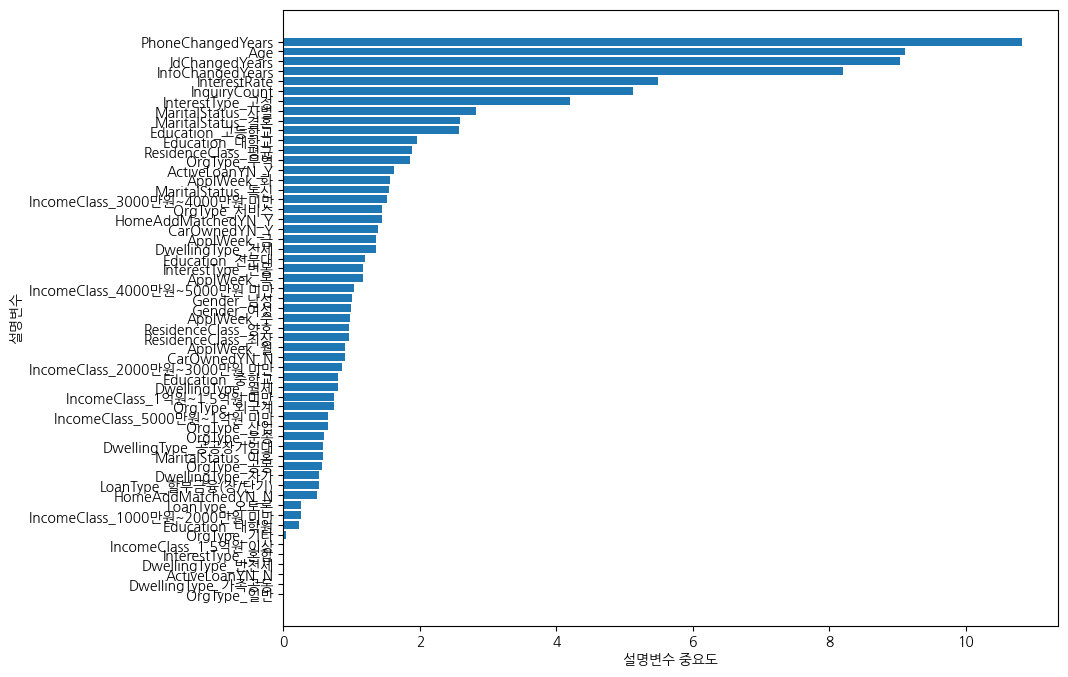

In [ ]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_cbc_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_cbc_importance ))
plt.barh(y = coordinates, width = df_cbc_importance ["Importance"])
plt.yticks(coordinates, df_cbc_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

# TEST

In [ ]:
df = pd.merge(dfc_test,dfloan_test, how='right',on='CustomerId')

In [ ]:
df = df.drop(['CustomerId','LoanId','HouseAge', 'WorkAddMatchedYN'], axis = 1)
df_em = df[(df['IncomeType'] == '퇴직')]
df_em = df_em.drop('EmployedYears', axis=1)

In [ ]:
df_em = df_em.dropna(subset=['PhoneChangeYears'])
df_em = df_em.dropna(subset=['IdChangedYears'])

In [ ]:
df_em = df_em.drop(['ScoreA', 'ScoreB','ScoreC','Occupation', 'IncomeType'], axis=1)

In [ ]:
df_em.isnull().sum()

Gender                 0
Age                    0
Education              0
MaritalStatus          0
FamilyCount            0
ChildCount             0
IncomeClass            0
OrgType                0
HouseOwnYN             0
DwellingType           0
HousingType            0
ResidenceClass         0
CarOwnedYN             0
Default             7763
ActiveLoanYN           0
LoanType               0
ApplWeek               0
ApplHour               0
Accompany              0
CarPrice               0
Deposit                0
LoanTerm               0
LoanRemainTerm         0
InterestType           0
InterestRate        7763
LoanAmount             0
InstallAmount       7763
LoanRemainAmount       0
HomeAddMatchedYN       0
InquiryCount           0
IdChangedYears         0
InfoChangedYears       0
PhoneChangeYears       0
dtype: int64

In [ ]:
df_em = df_em[df_em['IncomeClass'] != '누락']
df_em = df_em[df_em['ResidenceClass'] != '누락']
df_em = df_em[df_em['DwellingType'] != '정보누락']

In [ ]:
df_em['Accompany'].replace(['기타','배우자','친지','자녀','단체'],'동행', inplace = True)

In [ ]:
df_em = df_em.drop(['Default', 'InterestRate','InstallAmount'], axis=1)

* 신규 고객 데이터이기 때문에 연체여부, 금리, 월납입금액 삭제

In [ ]:
df_test = pd.get_dummies(df_em)

In [ ]:
# df_test

In [ ]:
import lightgbm as lgb
from xgboost import XGBClassifier as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
print(df_test.columns)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

Index(['Age', 'FamilyCount', 'ChildCount', 'ApplHour', 'CarPrice', 'Deposit',
       'LoanTerm', 'LoanRemainTerm', 'LoanAmount', 'LoanRemainAmount',
       'InquiryCount', 'IdChangedYears', 'InfoChangedYears',
       'PhoneChangeYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교',
       'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교',
       'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별',
       'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상',
       'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만',
       'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만',
       'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만',
       'OrgType_공공', 'OrgType_군/경', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업',
       'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'HouseOwnYN_N',
       'HouseOwnYN_Y', 'DwellingType_가족공동', 'DwellingType_공공장기임대',
       'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가',
       'DwellingType_전세', 'HousingType_단독주택

In [ ]:
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (9664, 57)
train data Y size : (9664,)
test data X size : (4142, 57)
test data Y size : (4142,)


In [ ]:
params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

X_train, X_valid, y_train, y_valid = train_test_split(df_train_x, df_train_y, test_size=0.2)

xgboost_uncust


train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

* f1 score 점수가 가장 높은 LightGBM 모델 선택 (0.172)

In [ ]:
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data])

/home/piai/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 7731, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.054068


In [ ]:
# 테스트 데이터 로드 또는 생성
X_test= df_test_x
# 모델을 사용하여 예측

In [ ]:
X_test

,Age,InterestRate,InquiryCount,IdChangedYears,InfoChangedYears,PhoneChangedYears,Gender_남성,Gender_여성,Education_고등학교,Education_대학교,...,ApplWeek_금,ApplWeek_목,ApplWeek_수,ApplWeek_월,ApplWeek_화,InterestType_고정,InterestType_변동,InterestType_혼합,HomeAddMatchedYN_N,HomeAddMatchedYN_Y
4547,60.2,5.19,0,12.5,0.0,2.2,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1
19294,61.5,4.43,0,8.5,1.9,1.8,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3563,63.3,5.19,1,0.0,33.4,8.1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
46359,65.5,5.10,0,12.5,17.1,1.1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
80738,62.5,5.23,5,2.5,2.4,2.1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66903,56.0,4.43,4,10.7,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
8576,56.5,4.30,1,10.6,9.2,0.7,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1
87388,61.3,6.83,0,13.5,1.3,4.9,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
42002,52.2,4.43,8,0.0,1.6,2.3,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [ ]:
predictions = bst.predict(X_test, num_iteration=bst.best_iteration)

In [ ]:
# 예측값 (이진 분류의 경우 0 또는 1)
binary_predictions = (predictions > 0.4).astype(int)

# 예측 확률
predictions[predictions < 0] = 0.01
prediction_probabilities = predictions

# 결과 확인
results = pd.DataFrame({'Prediction': binary_predictions, 'Probability': prediction_probabilities})
results

,Prediction,Probability
0,0,0.063291
1,0,0.030843
2,0,0.181886
3,0,0.029014
4,0,0.092533
...,...,...
4137,0,0.073136
4138,0,0.082577
4139,0,0.010000
4140,0,0.145595


* 연체일 확률이 40%보다 높으면 1로 분류, 낮으면 0으로 분류

In [ ]:
results['Prediction'].value_counts()

0    4136
1       6
Name: Prediction, dtype: int64

In [ ]:
results[results['Prediction'] == 1]

,Prediction,Probability
308,1,0.497116
682,1,0.491376
1236,1,0.453816
1374,1,0.484783
1803,1,0.413382
2693,1,0.631411


* 신규 고객 데이터에서 연체 위험 고객 6명 확인

* 확률을 활용하여 등급 세분화

  (1-P)*1000 = 신용 점수

## 결론

- 연체예측 모델을 만들고, 신규 데이터에 대해 연체 여부를 예측해 보았다.
- SMOTE 기법을 사용했을 때 F1-SCORE 값이 크게 증가하는 것은 추후 더 많은 데이터가 수집되었을 때 모델의 성능이 더욱 올라갈 수 있음을 방증
- 연체될 확률 값을 가지고 점수로 환산하여 구간별 금리 책정 가능
- 더 많은 변수가 추가될 시 연체 예측 모델의 성능 향상을 기대할 수 있음.